In [1]:
from __future__ import print_function
import numpy as np
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from torch.distributions import ContinuousBernoulli
import os 
os.chdir("/Probabilistic_Deep_Learning/")


DIM = 20
EPOCHS = 10
torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False,
                   transform=transforms.ToTensor()),
    batch_size=128, shuffle=False)

# TA model in sheet3_solution.ipynb
class CBVAE(nn.Module):
    def __init__(self, hidden_dims=[500, 500, DIM, 500, 500], data_dim=784):
        super().__init__()
        assert len(hidden_dims) == 5, "Insufficiently number of dimensions!"
        self.data_dim = data_dim
        self.device = device
        # define IO
        self.in_layer = nn.Linear(data_dim, hidden_dims[0])
        self.out_layer = nn.Linear(hidden_dims[-1], data_dim)
        # hidden layer
        self.enc_h = nn.Linear(hidden_dims[0], hidden_dims[1])
        # define hidden and latent
        self.enc_mu = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.enc_sigma = nn.Linear(hidden_dims[1], hidden_dims[2])
        # hidden layer decoder
        self.dec_h = nn.Linear(hidden_dims[2], hidden_dims[-2])
        self.dec_layer = nn.Linear(hidden_dims[-2], hidden_dims[-1])
        self.to(device)

    def encode(self, x: torch.Tensor):
        h1 = F.dropout(F.relu(self.in_layer(x)), p=0.1)
        h2 = F.dropout(F.relu(self.enc_h(h1)), p=0.1)
        return self.enc_mu(h2), self.enc_sigma(h2)

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        h3 = F.dropout(F.relu(self.dec_h(z)), p=0.1)
        h4 = F.dropout(F.relu(self.dec_layer(h3)), p=0.1)
        temp = torch.sigmoid(self.out_layer(h4))
        temp = ContinuousBernoulli(probs=temp) 
        return temp.mean

    def forward(self, x: torch.Tensor):
        mu, logvar = self.encode(x.view(-1, self.data_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


model = CBVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


# https://github.com/cunningham-lab/cb_and_cc
# the following function is copied from the above github repo
# where I ported from tensorflow to pytorch
def cont_bern_log_norm(lam, l_lim=0.49, u_lim=0.51):
    # computes the log normalizing constant of a continuous Bernoulli distribution in a numerically stable way.
    # returns the log normalizing constant for lam in (0, l_lim) U (u_lim, 1) and a Taylor approximation in
    # [l_lim, u_lim].
    # cut_y below might appear useless, but it is important to not evaluate log_norm near 0.5 as torch.where evaluates
    # both options, regardless of the value of the condition.
    cut_lam = torch.where(torch.logical_or(torch.less(lam, l_lim), torch.greater(
        lam, u_lim)), lam, l_lim * torch.ones_like(lam))
    log_norm = torch.log(torch.abs(
        2.0 * torch.atanh(1 - 2.0 * cut_lam))) - torch.log(torch.abs(1 - 2.0 * cut_lam))
    taylor = np.log(2.0) + 4.0 / 3.0 * torch.pow(lam - 0.5, 2) + \
        104.0 / 45.0 * torch.pow(lam - 0.5, 4)
    return torch.where(torch.logical_or(torch.less(lam, l_lim), torch.greater(lam, u_lim)), log_norm, taylor)

# https://github.com/Robert-Aduviri/Continuous-Bernoulli-VAE
# the following function is copied from the above github repo
# where I did not alter anything
def sumlogC(x, eps=1e-5):
    '''
    Numerically stable implementation of 
    sum of logarithm of Continous Bernoulli
    constant C, using Taylor 2nd degree approximation

    Parameter
    ----------
    x : Tensor of dimensions (batch_size, dim)
        x takes values in (0,1)
    '''
    x = torch.clamp(x, eps, 1.-eps)
    mask = torch.abs(x - 0.5).ge(eps)
    far = torch.masked_select(x, mask)
    close = torch.masked_select(x, ~mask)
    far_values = torch.log(
        (torch.log(1. - far) - torch.log(far)).div(1. - 2. * far))
    close_values = torch.log(torch.tensor((2.))) + \
        torch.log(1. + torch.pow(1. - 2. * close, 2)/3.)
    return far_values.sum() + close_values.sum()

# Reconstruction + KL divergence losses summed over all elements and batch


def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    logC = sumlogC(recon_x)
    # logCC = cont_bern_log_norm(recon_x).sum()
    # print(torch.abs(logC - logCC))
    # losses.append((BCE.item(), KLD.item(), logCC.item()))
    return BCE, KLD, logC


def train(epoch):
    model.train()
    train_loss = 0
    train_loss_vals = []
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        train_loss_vals.append(sum([temp.item() for temp in loss]))
        loss = sum(loss)
        loss.backward()
        train_loss += loss.item()

        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    train_loss /= len(train_loader.dataset)
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss))
    return np.array(train_loss_vals) / len(train_loader.dataset) * len(train_loader)


def test(epoch):
    model.eval()
    test_loss = 0
    test_loss_vals = []
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            test_loss_vals.append(sum([temp.item() for temp in loss]))
            loss = sum(loss)
            test_loss += loss

            if i == 0:
                n = min(data.size(0), 8)
                recon_batch = recon_batch.view(128, 1, 28, 28)
                comparison = torch.cat([data[:n],
                                        recon_batch[:n]])

                save_image(comparison.cpu(),
                            'cbresults/reconstruction_' + str(epoch) + '.png', nrow=n)
                # plt.figure(figsize=(10, 4))
                # for i in range(1, 2*n+1):
                #     ax = plt.subplot(2, n, i)
                #     plt.imshow(comparison.cpu().detach().numpy()
                #                [i-1, 0, :, :], cmap="gray")
                #     ax.get_xaxis().set_visible(False)
                #     ax.get_yaxis().set_visible(False)
                #     ax.margins(0, 0)
                # plt.savefig('cbresults/reconstruction_' + str(epoch) + '.png')
                # plt.close()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return np.array(test_loss_vals) / len(test_loader.dataset) * len(test_loader)


train_loss_vals_total = np.array([])
test_loss_vals_total = np.array([])
for epoch in range(1, EPOCHS + 1):
    train_loss = train(epoch)
    train_loss_vals_total = np.append(train_loss_vals_total, train_loss)
    test_loss = test(epoch)
    test_loss_vals_total = np.append(test_loss_vals_total, test_loss)
    # with torch.no_grad():
    #     sample = torch.randn(64, DIM).to(device)
    #     sample = model.decode(sample).cpu()
    #     save_image(sample.view(64, 1, 28, 28),
    #                'cbresults/sample_' + str(epoch) + '.png')
    

torch.save(model, 'trained_models/cbvae.pt')
# np.save("tmp/cbvae_train_loss_vals_total.npy", train_loss_vals_total)
# np.save("tmp/cbvae_test_loss_vals_total.npy", test_loss_vals_total)


Train Epoch: 1 [0/60000 (0%)]	Loss: 1086.890991
Train Epoch: 1 [1280/60000 (2%)]	Loss: 933.448425
Train Epoch: 1 [2560/60000 (4%)]	Loss: 928.139893
Train Epoch: 1 [3840/60000 (6%)]	Loss: 922.268066
Train Epoch: 1 [5120/60000 (9%)]	Loss: 924.223328
Train Epoch: 1 [6400/60000 (11%)]	Loss: 923.835693
Train Epoch: 1 [7680/60000 (13%)]	Loss: 924.590942
Train Epoch: 1 [8960/60000 (15%)]	Loss: 925.373413
Train Epoch: 1 [10240/60000 (17%)]	Loss: 922.582520
Train Epoch: 1 [11520/60000 (19%)]	Loss: 921.640015
Train Epoch: 1 [12800/60000 (21%)]	Loss: 921.642822
Train Epoch: 1 [14080/60000 (23%)]	Loss: 926.230957
Train Epoch: 1 [15360/60000 (26%)]	Loss: 922.443115
Train Epoch: 1 [16640/60000 (28%)]	Loss: 924.295532
Train Epoch: 1 [17920/60000 (30%)]	Loss: 921.519958
Train Epoch: 1 [19200/60000 (32%)]	Loss: 921.140747
Train Epoch: 1 [20480/60000 (34%)]	Loss: 923.309448
Train Epoch: 1 [21760/60000 (36%)]	Loss: 919.221069
Train Epoch: 1 [23040/60000 (38%)]	Loss: 916.959351
Train Epoch: 1 [24320/60000

In [2]:
# with torch.no_grad():
#     sample = torch.randn(128, 20).to('cpu')
#     sample = model.decode(sample).cpu()
#     save_image(sample.view(128, 1, 28, 28),
#         'results/sample_cb_relu' + str(EPOCHS) + '.png')

#plot sample image
# plt.figure(figsize=(10, 4))
# n = 8
# for i in range(1, 4*n+1):
#     # display original
#     ax = plt.subplot(4, n, i)
#     plt.imshow(sample.view(128, 1, 28, 28).cpu().detach().numpy()[i-1, 0, :, :], cmap="gray")
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)

# print(sample)

Text(0.5, 1.0, 'CBVAE ELBO loss over batches')

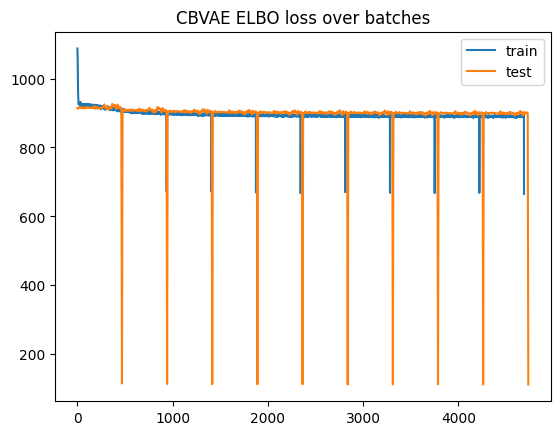

In [3]:
plt.figure()
plt.plot(train_loss_vals_total, label="train")
plt.plot([i*6 for i in range(len(test_loss_vals_total))], test_loss_vals_total, label="test")
plt.legend()
plt.title("CBVAE ELBO loss over batches") 